# Homework 3
## Part 3
Let's build an optimized mosaic with 29 images! Most comments, citations, etc. are discussed in part 2 and taken out of part 3 to avoid redundancy and reduce length.

Differences: no homography check like in part 2, my kernel crashed when I ran it.

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import os
import itertools

In [2]:
imgs = []
dir_name = '29images_nocolumns/'
list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(dir_name + '*') ) )
# Iterate over sorted list of files and print the file paths 
# one by one.
for file_path in list_of_files:
    imgs.append(cv2.imread(file_path))


In [3]:
len(imgs)

28

In [4]:
# image normalization
def normalizeImgs(imgs):
    normImgs = []
    for img in imgs:
        norm_img = np.zeros(img.shape[:2])
        final_img = cv2.normalize(img,norm_img,0,255,cv2.NORM_MINMAX)
        normImgs.append(final_img)
    return normImgs
    
normImgs = normalizeImgs(imgs)

In [5]:
def convertToGray(normImgs):
    grayImgs = []
    for img in normImgs:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grayImgs.append(gr)
    return grayImgs


In [6]:
def claheImages(imgs):
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    for img in imgs:
        clahe.apply(img) + 30
    return imgs

In [7]:
grayImgs = convertToGray(normImgs)
image_height, image_width = grayImgs[0].shape
camera_matrix = np.array([[1, 0, image_width/2],
                          [0, 1, image_height/2],
                          [0, 0, 1]])
#processedImgs = claheImages(grayImgs)


In [8]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=4000,nOctaveLayers=12,contrastThreshold=0.025,sigma=1.5)
#sift = cv2.xfeatures2d.SIFT_create()

In [9]:
def get_non_max_suppression_mask(keypoints):
    binary_image = np.zeros((image_height, image_width))
    response_list = np.array([keypoint.response for keypoint in keypoints])
    mask = np.flip(np.argsort(response_list))
    point_list = np.rint([keypoint.pt for keypoint in keypoints])[
        mask].astype(int)
    non_max_suppression_mask = []
    for point, index in zip(point_list, mask):
        if binary_image[point[1], point[0]] == 0:
            non_max_suppression_mask.append(index)
            cv2.circle(binary_image, (point[0], point[1]), 2, 255, -1)

    return non_max_suppression_mask

In [10]:
def featureDetector(sift_obj, grayImgs):
    kp = []
    des = []
    outImages = []
    for gr in grayImgs:
        k, d = sift_obj.detectAndCompute(gr,None)
        non_max_suppression_mask = get_non_max_suppression_mask(k) # source: ZZ
        outImage = cv2.drawKeypoints(gr, k, gr,color=[255,255,0],
                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        #kps = np.array(k)[non_max_suppression_mask]
        #norm_keypoints(kps)
        #kp.append(kps)
        
        kp.append(np.array(k)[non_max_suppression_mask])
        des.append(np.array(d)[non_max_suppression_mask])
        outImages.append(outImage)
        
    return kp, des, outImages

In [11]:
kp, des, outImages = featureDetector(sift, grayImgs)

In [12]:
def knn_match_and_lowe_ratio_filter(matcher, des1, des2,threshold=0.90, dist_mask_12=None, draw_plot_dist=False):
    # First match 2 against 1
    if dist_mask_12 is None:
        dist_mask_21 = None
    else:
        dist_mask_21 = dist_mask_12.T
    matches_knn = matcher.knnMatch(des2,des1, k=2, mask = dist_mask_21 )
    all_ds = [m[0].distance for m in matches_knn if len(m) >0]

    #print("Len of knn matches", len(matches_knn))

    matches = []
    # Run lowes filter and filter with difference higher than threshold this might
    # still leave multiple matches into 1 (train descriptors)
    # Create mask of size des1 x des2 for permissible matches
    mask = np.zeros((des1.shape[0],des2.shape[0]),dtype='uint8')
    for match in matches_knn:
        if len(match)==1 or (len(match)>1 and match[0].distance < threshold*match[1].distance):
           # if match[0].distance < 75:
                matches.append(match[0])
                mask[match[0].trainIdx,match[0].queryIdx] = 1

    #matches = [m for m in matches if m.distance<5 ]

    if draw_plot_dist:
        fig, axes = plt.subplots(1, 1, num=3)
        filt_ds = [m.distance for m in matches]
        axes.plot(sorted(all_ds),'.',label = 'All Matches')
        axes.plot(sorted(filt_ds),'.',label = 'Filtered Matches')
        axes.set_xlabel('Number')
        axes.set_ylabel('Distance')
        axes.legend()
        plt.pause(.1)

    # run matches again using mask but from 1 to 2 which should remove duplicates
    # This is basically same as running cross match after lowe ratio test
    matches_cross = matcher.match(des1,des2,mask=mask)
    #print("Len of cross matches", len(matches_cross))
    return matches_cross

In [13]:
def getMatches(kp, des, onlyImagePair=False):
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = []
    # kp_match is a list of tuples with kp_match[i] = (kp0_match, kp1_match)
    kp_match = [] 
    if onlyImagePair:
        matches.append(knn_match_and_lowe_ratio_filter(matcher,des[0],des[1],threshold=0.90))
        kp0_match_pts = np.array([kp[0][mat.queryIdx].pt for mat in matches[0]])
        kp1_match_pts = np.array([kp[1][mat.trainIdx].pt for mat in matches[0]])
        kp_match.append((kp0_match_pts,kp1_match_pts))
    else:
        # do sequential matching
        for i in range(len(kp)):
            if i < len(kp) - 1:
                # match with next pair
                matches.append(knn_match_and_lowe_ratio_filter(matcher,des[i],des[i+1],threshold=0.90))
                kp0_match_pts = np.array([kp[i][mat.queryIdx].pt for mat in matches[i]])
                kp1_match_pts = np.array([kp[i+1][mat.trainIdx].pt for mat in matches[i]])
            else:
                # if i is at last image index, match the last image with the first image (6-1)
                matches.append(knn_match_and_lowe_ratio_filter(matcher,des[i],des[0],threshold=0.90))
                kp0_match_pts = np.array([kp[i][mat.queryIdx].pt for mat in matches[i]])
                kp1_match_pts = np.array([kp[0][mat.trainIdx].pt for mat in matches[i]])


            kp_match.append((kp0_match_pts,kp1_match_pts))
    return matches, kp_match

In [14]:
matches, kp_match = getMatches(kp,des)

In [15]:
def getInliers(kp, des, matches, kp_match):
    # use findFundamentalMatrix function to do RANSAC and assemble an inlier list
    mask_e = []
    kp_match_inliers = []
    i = 0
    for k_match in kp_match:
        F, maskMatch = cv2.findFundamentalMat(k_match[0], k_match[1],
                                             method=cv2.FM_RANSAC,       
                                             ransacReprojThreshold=1.0,
                                             confidence=0.9999)
        mask_e.append(maskMatch)
        
        kp0_match_inliers = [kp[i][mat.queryIdx] for mat, msk in zip(matches[i], mask_e[i]) if msk]
        if i < 5:
            kp1_match_inliers = [kp[i+1][mat.trainIdx] for mat, msk in zip(matches[i], mask_e[i]) if msk]
        else:
            kp1_match_inliers = [kp[0][mat.trainIdx] for mat, msk in zip(matches[i], mask_e[i]) if msk]
            
        kp_match_inliers.append((kp0_match_inliers,kp1_match_inliers))
        i+=1
        
    return kp_match_inliers, mask_e

In [16]:
#kp_match_inliers, mask_e = getInliers(kp, des, matches, kp_match)


In [17]:
# returns a list of homographies for each image pair of keypoints given
# the homographies map the left image (src) to the right image (dst)
# UPDATE 27FEB:
# declare pts_left_src and pts_right_dst as global variables so that I can utilize them later
pts_left_src = []
pts_right_dst = []
def getHomography(kp_match_inliers, inliers = True):
    global pts_left_src
    global pts_right_dst
    pts_left_src = []
    pts_right_dst = []
    h = []
    mask = []
    if inliers:
        for kp_match in kp_match_inliers:
            pts_left_src.append(np.float32([kp_match[0][i].pt for i in range(len(kp_match[0]))]))
            #print(pts_left_src)
            pts_right_dst.append(np.float32([kp_match[1][i].pt for i in range(len(kp_match[1]))]))
    else:
        # if inliers were not already given to the homography function, get points and do RANSAC
        for kp_match in kp_match_inliers:
            pts_left_src.append(np.float32([kp_match[0][i] for i in range(len(kp_match[0]))]))
            #print(pts_left_src)
            pts_right_dst.append(np.float32([kp_match[1][i] for i in range(len(kp_match[1]))]))
    
    # this is only for the last run
    for i in range(len(pts_left_src)):
        if inliers:
            # switched these 19FEB
            h_img, mask_img = cv2.findHomography(pts_right_dst[i],pts_left_src[i])
            #h_img, mask_img = cv2.findHomography(pts_left_src[i],pts_right_dst[i])
        else:
            h_img, mask_img = cv2.findHomography(pts_right_dst[i],pts_left_src[i],cv2.RANSAC,1.0)
            #h_img, mask_img = cv2.findHomography(pts_left_src[i],pts_right_dst[i],cv2.RANSAC,1.0)
        h.append(h_img)
        mask.append(mask_img)
    return h, mask

In [18]:
#h = getHomography(kp_match_inliers)
#print(kp_match[0][0])
# 1's in the mask are inliers
print(len(kp))
h, mask = getHomography(kp_match, inliers=False)
#print(np.count_nonzero(mask[5]))


28


In [19]:
def alpha_blending(img1, img2):
    mask1 = cv2.inRange(img1,np.array([0, 0, 0]),np.array([5, 5, 5]))
    mask2 = cv2.inRange(img2,np.array([0, 0, 0]),np.array([5, 5, 5]))
    mask1 = cv2.bitwise_not(mask1)
    mask2 = cv2.bitwise_not(mask2)
    mask = cv2.bitwise_and(mask1, mask2)
    mask_inv = cv2.bitwise_not(mask)
    img1_fg = cv2.bitwise_and(img1,img1,mask = mask)
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    img_fg = cv2.addWeighted(img1_fg,0.7,img2_fg,0.3,0)
    img1_bg = cv2.bitwise_and(img1,img1,mask = cv2.bitwise_and(mask1,mask_inv))
    img2_bg = cv2.bitwise_and(img2,img2,mask = cv2.bitwise_and(mask2,mask_inv))
    img = cv2.add(img2_bg,img1_bg)
    img = cv2.add(img,img_fg)
    return img


In [20]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[[0,0],[0,h1],[w1,h1],[w1,0]]]).reshape(-1,1,2)
    pts2 = np.float32([[[0,0],[0,h2],[w2,h2],[w2,0]]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    shift = pts2_[0][0]
    Ht = np.asarray([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    H_t = np.dot(np.eye(3),np.asarray([[1,0,t[0]],[0,1,t[1]],[0,0,1]]))
    tmp = cv2.warpPerspective(img1, H_t, (xmax-xmin, ymax-ymin))
    output = alpha_blending(result,tmp)
    return output,t

In [21]:
#h = getHomography(kp_match_inliers)
h, mask = getHomography(kp_match, inliers=False)
def buildMosaic(h, normImgs):
    t = [0,0]
    #mosaicImgs = []
    for i in range(len(h)-1):
        #print(t)
        #print(h[i])
        h[i][0][2] += t[0]
        h[i][1][2] += t[1]
        if i != 0:
            h[i] = np.dot(h[i],h[i-1])
            
        if i == 0:
            mosaicImg, t = warpTwoImages(normImgs[i],normImgs[i+1],h[i])

        elif i > 0 and i < (len(h)): #len(h) or len(h) - 1?
            mosaicImg, t = warpTwoImages(mosaicImg,normImgs[i+1],h[i])

        else:
            mosaicImg, t = warpTwoImages(mosaicImg,normImgs[0],h[i])
    
    return mosaicImg

mosaicImg = buildMosaic(h, normImgs)
#plt.figure(figsize = (12,12))
#plt.imshow(mosaicImg)

In [22]:
def shoelaceArea(x_y):
    x_y = np.array(x_y)
    x_y = x_y.reshape(-1,2)

    x = x_y[:,0]
    y = x_y[:,1]

    S1 = np.sum(x*np.roll(y,-1))
    S2 = np.sum(y*np.roll(x,-1))

    area = .5*np.absolute(S1 - S2)

    return area

In [23]:
def checkNewImageArea(h):
    # homogenous image dimension points
    originalPoints = np.array([[0,0,1],
                               [image_width,0,1],
                               [image_width-1,image_height,1],
                               [0,image_height,1]])
    
    transformedPts = np.zeros((4,2))
    i = 0
    for pts in originalPoints:
        newPts = np.matmul(h,pts)
        transformedPts[i] = newPts[:2]
        i+=1
        
    originalArea = shoelaceArea(originalPoints[:,:2])
    warpedArea = shoelaceArea(transformedPts)
    areaRatio = warpedArea / originalArea
    if areaRatio < 1.10 and areaRatio > 0.90:
        return True
    else: 
        return False

In [24]:
checkNewImageArea(h[0])

True

In [25]:
def isHomographyGood(h):
    hR = h[0:2,0:2]
    #if np.linalg.det(hR) > 0 and checkNewImageArea(h):
    if np.linalg.det(hR) > 0:
        return True
    else:
        return False

In [26]:
# do image pair 1-6
# create function that does this between two images easily.
def registerTwoImages(imgList,index1,index2,kp,des):
    gray16 = [imgList[index1], imgList[index2]]
    kp16 = [kp[index1],kp[index2]]
    des16 = [des[index1],des[index2]]
    match, kp_match = getMatches(kp16,des16, onlyImagePair=True)
    kp_match_inliers, mask_e = getInliers(kp16, des16, match, kp_match)
    
    #matchImgs = drawInliers(gray16,match,kp_match_inliers,mask_e)
    h, mask = getHomography(kp_match, inliers=False)
    #print(isHomographyGood(h[0]))
    result,t  = warpTwoImages(normImgs[index2],normImgs[index1],h[0])
    #return result
    
    return h, mask

#result16 = registerTwoImages(grayImgs,0,5,kp,des)
#plt.imshow(result16)

In [27]:
import g2o
import gtsam
import gtsam.utils.plot

In [28]:
def getOdometryNoise(mask):
    numMatches = np.count_nonzero(mask)
    # define error lists in the form of [xerr,yerr,theta_err]
    minError = [0.2, 0.2, 0.1]
    smallError = [0.5, 0.5, 0.25]
    largeError = [0.8, 0.8, 0.4]
    maxError = [1.0, 1.0, 0.5]
    
    if numMatches > 100:
        err = minError
    elif numMatches > 50 and numMatches <= 100:
        err = smallError
    elif numMatches > 20 and numMatches <= 50:
        err = largeError
    else:
        # less than 20 inlier matches
        err = maxError
    
    return gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(err[0], err[1], err[2]))

In [29]:
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))
graph = gtsam.NonlinearFactorGraph()

# add a prior on the first pose at origin (image 0 center)
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(image_width/2, image_height/2, 0), PRIOR_NOISE))

In [30]:
ransac_mask = []
def getFactorPose(index, pts_src = pts_left_src, pts_dst = pts_right_dst):
    global ransac_mask
    # pts_src and pts_dst do not need to be iterated through
    # keep src/dst order consistent
    similarity_mat, ransac_mask = cv2.estimateAffinePartial2D(pts_dst[index],pts_src[index])
    if np.count_nonzero(ransac_mask) > 10:
        scale = np.sqrt(similarity_mat[0, 0]**2+similarity_mat[1, 0]**2)
        similarity_mat[:2, :2] /= scale
        affine_matrix = np.vstack((similarity_mat, [0, 0, 1]))
        # NOTE: INVERTED ON 01MAR
        #affine_matrix = np.linalg.inv(affine_matrix)
        #print(affine_matrix)
        return gtsam.Pose2(affine_matrix[0, -1], affine_matrix[1, -1],
                    np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0]))
    else:
        #return gtsam version of None
        return None # TODO: Check this
        
getFactorPose(0)

(-13.8216, 124.344, -0.00802838)

In [31]:
def extractHomographyPose(h):
    affineEst = h
    affineEst[2][0] = 0
    affineEst[2][1] = 0
    #print(affineEst)
    scale = np.sqrt(affineEst[0,0]**2+affineEst[1,0]**2) # adapted from ZZ
    affineEst[:2, :2] /= scale
    rot = affineEst[:2, :2]
    total_affine_matrix = np.eye(3)

    affineEst_inv = np.linalg.inv(affineEst)
    affineEst = affineEst_inv.dot(total_affine_matrix)
    return gtsam.Pose2(affineEst[0, -1], affineEst[1, -1],
                    np.arctan2(affineEst[1, 0], affineEst[0, 0]))

In [32]:
def initialEstimates(h):
    initial_estimate = gtsam.Values()
    initial_estimate.insert(0, gtsam.Pose2())
    
    for i in range(len(h)-1):
        initial_estimate.insert(i+1, extractHomographyPose(h[i]))
        
    return initial_estimate

initial = initialEstimates(h)

In [33]:
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()):
        gtsam.utils.plot.plot_pose2(0, values.atPose2(
            vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]:
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

In [34]:
def check_overlap(pose_1, pose_2):
    #print(cv2.norm(pose_1.translation()-pose_2.translation()))
    return cv2.norm(pose_1.translation()-pose_2.translation()) < image_width

In [35]:
print(image_width)

576


In [36]:
# nonlinear graph initialization done earlier
for src_index, dst_index in itertools.combinations(range(len(normImgs)), 2):
    #print(dst_index)
    #print(check_overlap(initial.atPose2(src_index), initial.atPose2(dst_index)))

    if src_index + 1 == dst_index:
        print(src_index)
        graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                               getFactorPose(src_index), getOdometryNoise(mask[src_index])))
            
    else: 
    # 
    #elif src_index + 2 == dst_index or src_index - 2 == dst_index or src_index - 1 == dst_index:
    #elif src_index + 2 == dst_index or src_index - 2 == dst_index or src_index - 1 == dst_index or dst_index % 7 < 3:
    #elif check_overlap(initial.atPose2(src_index), initial.atPose2(dst_index)):
        # NOTE: Need to change this to check only images immediately next to it
        #homog, maskIm = registerTwoImages(normImgs,src_index,dst_index,kp,des)
        #if isHomographyGood(homog[0]):
            
        kpList = [kp[src_index],kp[dst_index]]
        desList = [des[src_index],des[dst_index]]
        match_overlap, kp_match_overlap = getMatches(kpList,desList, onlyImagePair=True)
        homog, maskIm = getHomography(kp_match_overlap, inliers=False)
        #if isHomographyGood(homog[0]):
        pts_left_overlap = []
        pts_right_overlap = []
        for kp_matches in kp_match_overlap:
            pts_left_overlap.append(np.float32([kp_matches[0][i] for i in range(len(kp_matches[0]))]))
            #print(pts_left_src)
            pts_right_overlap.append(np.float32([kp_matches[1][i] for i in range(len(kp_matches[1]))]))

        #print(len(pts_left_overlap[0]))
        factor_pose = getFactorPose(0, pts_left_overlap, pts_right_overlap)
        #print(factor_pose)
        if factor_pose is not None:
            graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                factor_pose, getOdometryNoise(ransac_mask)))


True
0
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
1
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
2
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
3
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
4
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
5
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
6
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
7
True
True
True
False
False

In [37]:
#print(len(pts_left_overlap))

Plot graph before optimization

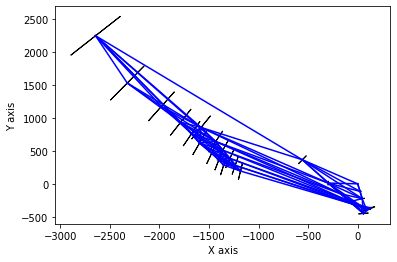

In [38]:
#graph = build_graph(initial)
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

Plot graph after optimization

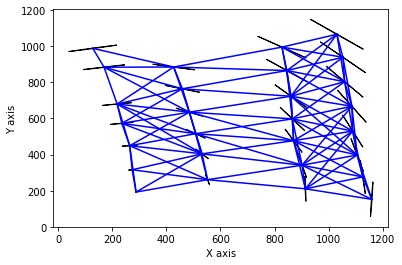

In [39]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)


#params = gtsam.GaussNewtonParams()
# Stop iterating once the change in error between steps is less than this value
#params.setRelativeErrorTol(1e-5)
# Do not perform more than N iteration steps
#params.setMaxIterations(100)
#optimizer = gtsam.GaussNewtonOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

In [40]:
def extractAffineMatrixList(initial, image_list):
    poses = gtsam.utilities.allPose2s(initial)
    affine_matrix_list = []

    for index in range(len(image_list)):

        pose = poses.atPose2(index)
        #print(pose)
        #pose = [x * -1 for x in pose]
        affine_matrix = pose.matrix()
        #affine_matrix = np.linalg.inv(affine_matrix)
        translation_matrix = np.eye(3)

        translation_matrix[:2, 2] -= np.array([image_width/2, image_height/2]).T
        #print(affine_matrix.dot(translation_matrix))
        #affine_matrix_list.append(affine_matrix)
        affine_matrix_list.append(affine_matrix.dot(translation_matrix))
    
    #print(affine_matrix_list[0])
    affine_matrix_list.reverse()
    return affine_matrix_list

In [41]:
affine_matrix_list = extractAffineMatrixList(initial, normImgs)

In [42]:
def get_warp_point(homography_matrix, point):
    warp_point = homography_matrix.dot(np.append(point, [1]).T)
    return (warp_point / warp_point[-1])[:2]

In [43]:
def get_stitch_image_size_offset_affine_matrix(homography_matrix_list):
    corner_point_list = []

    for homography_matrix in homography_matrix_list:

        corner_point_list.append(get_warp_point(
            homography_matrix, [0, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [image_width - 1, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [image_width - 1, image_height - 1]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [0, image_height - 1]))

    min_point = (np.floor(np.amin(corner_point_list, axis=0))).astype(np.int32)
    max_point = (np.ceil(np.amax(corner_point_list, axis=0))).astype(np.int32)

    stitch_image_size = tuple(max_point - min_point + 1)

    offset_affine_matrix = np.eye(3, dtype=np.float64)
    if min_point[0] < 0:
        offset_affine_matrix[0, -1] -= min_point[0]
    if min_point[1] < 0:
        offset_affine_matrix[1, -1] -= min_point[1]
    return stitch_image_size, offset_affine_matrix

In [44]:
def get_stitch_image(homography_matrix_list, image_list, stitch_image_size, offset_affine_matrix):

    stitch_image = np.zeros(
        (stitch_image_size[1], stitch_image_size[0], 3), np.uint8)
    print(stitch_image.shape)
    image_list.reverse()
    for homography_matrix, image in zip(homography_matrix_list, image_list):
        
        warp_image = cv2.warpPerspective(
            image, offset_affine_matrix.dot(homography_matrix), stitch_image_size)
        #plt.imshow(warp_image)
        #break
        warp_image_mask = (warp_image != 0)
        stitch_image[warp_image_mask] = warp_image[warp_image_mask]
        
        
        output = alpha_blending(stitch_image,warp_image)
    

    return output

(1368, 1653, 3)


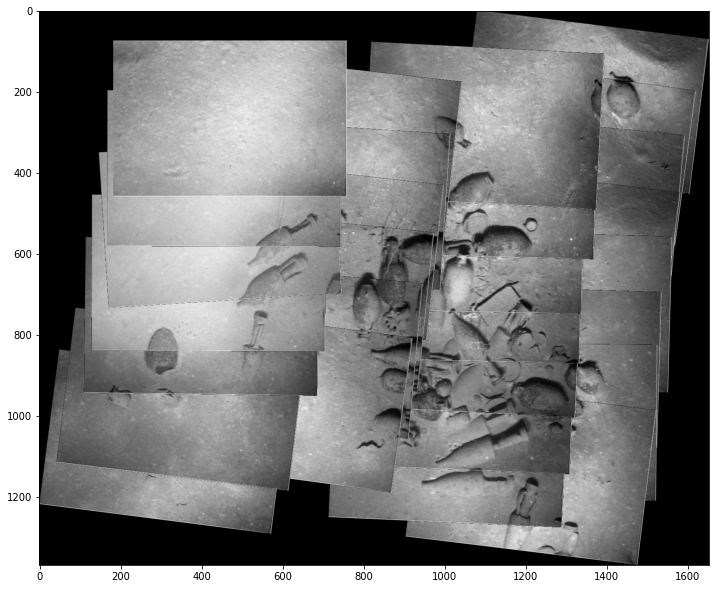

In [45]:
stitch_image_size, offset_affine_matrix = get_stitch_image_size_offset_affine_matrix(
    affine_matrix_list)

stitch_image = get_stitch_image(
    affine_matrix_list, normImgs, stitch_image_size, offset_affine_matrix)

plt.figure(figsize = (12,12))
plt.imshow(stitch_image)
plt.show()